In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import pprint


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


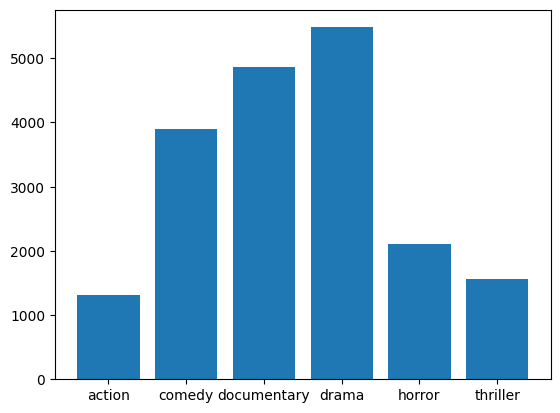

In [8]:
# Part 1.a
genres = ["action", "comedy", "documentary", "drama", "horror", "thriller"]
genres_count = {
    "action": 0,
    "comedy": 0,
    "documentary": 0,
    "drama": 0,
    "horror": 0,
    "thriller": 0
}
label_map = {
    "action": 0,
    "comedy": 1,
    "documentary": 2,
    "drama": 3,
    "horror": 4,
    "thriller": 5
}
genre_map = {
    0: "action",
    1: "comedy",
    2: "documentary",
    3: "drama",
    4: "horror",
    5: "thriller"
}
labels = []

train_df = pd.read_csv('data/train.csv', header=0).drop(columns=['f_1'])

labels_df = train_df['genre']

for _, genre in labels_df.items():
    genres_count[genre] += 1
    labels.append(label_map[genre])


plt.bar(genres, genres_count.values())

# validation labels
validation_genres_count = {
    "action": 0,
    "comedy": 0,
    "documentary": 0,
    "drama": 0,
    "horror": 0,
    "thriller": 0
}
validation_labels = []

validation_df = pd.read_csv('data/validate.csv', header=0).drop(columns=['f_1'])

validation_labels_df = validation_df['genre']

for _, genre in validation_labels_df.items():
    validation_genres_count[genre] += 1
    validation_labels.append(label_map[genre])


### Part a writeup
As seen in the plot above, there is a clear imbalance in the data. There are a lot more instances of comedy, documentary and drama movie types compared to the others

In [9]:
# 1.b
train_df = pd.read_csv('data/train.csv', header=0).drop(columns=['f_1'])

feature_tensor = torch.tensor(train_df.drop(columns=['genre']).values, device=device)
label_tensor = torch.tensor(labels, dtype=torch.long, device=device)

dataset = TensorDataset(feature_tensor, label_tensor)
dataloader = DataLoader(dataset, batch_size=64)

v_feature_tensor = torch.tensor(validation_df.drop(columns=['genre']).values, device=device)
v_label_tensor = torch.tensor(validation_labels, dtype=torch.long, device=device)

### Part c writeup
First, the f_1 column is dropped from dataset since it is not a part of the embeddings of a movie. Then the data is split into the embeddings and the label.
Finally, the data is loaded into a Pytorch dataloader with a batch size of 64 for training.

In [10]:
# 1.c
class SimpleNeuralNet(nn.Module):
    def __init__(self, num_layers, num_nodes):
        super().__init__()
        layers = []

        prev_size = 299
        for _ in range(num_layers):
            layers.append(nn.Linear(prev_size, num_nodes, dtype=torch.float64))
            layers.append(nn.ReLU())
            prev_size = num_nodes

        layers.append(nn.Linear(prev_size, 6, dtype=torch.float64)) # Output layer
        layers.append(nn.Softmax(-1))

        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.stack(x)
        return logits
    
    def train(self, dataloader, learning_rate, num_epochs, v_feature_tensor, v_label_tensor):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_error_list = []
        validation_error_list = []

        for i in range(num_epochs):
            running_loss = 0
            for inputs, label in dataloader:
                output = self(inputs)
                loss = criterion(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # report train and validation loss
            print(f"EPOCH {i}")
            validation_output = self(v_feature_tensor)
            train_error_list.append(running_loss/(len(dataloader)))
            validation_error_list.append(criterion(validation_output, v_label_tensor).item())
        
        return train_error_list, validation_error_list  


EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60
EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80
EPOCH 81
EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
EPOCH 97
EPOCH 98
EPOCH 99


TypeError: 'module' object is not callable. Did you mean: 'pprint.pprint(...)'?

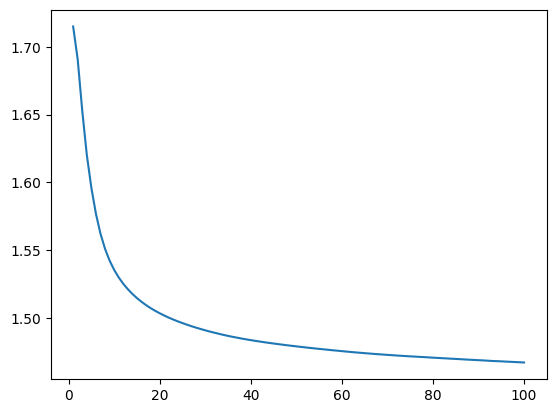

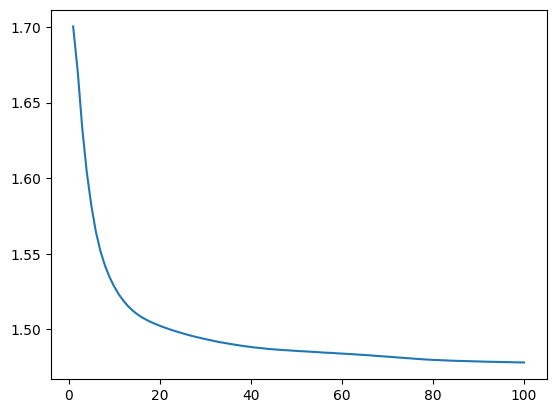

In [11]:
# 1.3 part i)
num_epoch = 100
model = SimpleNeuralNet(1, 32)

model = model.to(device)
    
train_error_list, validation_error_list = model.train(dataloader, 0.001, num_epoch, v_feature_tensor, v_label_tensor)
epoch_list = [i for i in range(1, num_epoch + 1)]
plt.figure(1)
plt.plot(epoch_list, train_error_list)
plt.figure(2)
plt.plot(epoch_list, validation_error_list)

# accuracy, class-wise and f1 score
class_accuracy_count = [0] * 6
accuracy_count = 0
confusion_matrix = [[0] * 6 for i in range(6)] # row is actual, col is predicted
class_accuracy_score = []

for i in range(len(v_feature_tensor)):
    feature = v_feature_tensor[i]
    label = v_label_tensor[i]

    prediction = model(feature)

    if torch.argmax(prediction, 0) == label:
        accuracy_count += 1
        class_accuracy_count[label] += 1

    confusion_matrix[label][torch.argmax(prediction, 0)] += 1

for class_i in range(6):
    class_accuracy_score.append({
        "TP": 0,
        "TN": 0,
        "FP": 0,
        "FN": 0,
        "AC_rate": 0,
        "F1": 0
    })

    class_accuracy_score[class_i]["TP"] = confusion_matrix[class_i][class_i]

    for row in range(6):
        for col in range(6):
            if row == class_i and col != class_i:
                class_accuracy_score[class_i]["FN"] += confusion_matrix[row][col]
            if col == class_i and row != class_i:
                class_accuracy_score[class_i]["FP"] += confusion_matrix[row][col]
            if row != class_i and col != class_i:
                class_accuracy_score[class_i]["TN"] += confusion_matrix[row][col]

    class_accuracy_score[class_i]["AC_rate"] = class_accuracy_count[class_i] / validation_genres_count[genre_map[class_i]]

    r = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FN"]) != 0 else 0
    p = (class_accuracy_score[class_i]["TP"]) / (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) if (class_accuracy_score[class_i]["TP"] + class_accuracy_score[class_i]["FP"]) != 0 else 0
    class_accuracy_score[class_i]["F1"] = 2*((p*r)/(p+r)) if (p+r) != 0 else 0

pprint(class_accuracy_score)
    


In [ ]:
# 1.d
class GoodNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        layers = []

        layers.append(nn.Conv1d(in_channels=1, out_channels=10, kernel_size=5, padding=1))
        layers.append(nn.MaxPool1d(kernel_size=3, stride=2))
        layers.append(nn.Linear(147, 100, dtype=torch.float64))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(100, 6, dtype=torch.float64)) # Output layer
        layers.append(nn.Softmax(-1))

        self.stack = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.stack(x)
        return logits
    
    def train(self, dataloader, learning_rate, num_epochs, v_feature_tensor, v_label_tensor):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        train_error_list = []
        validation_error_list = []

        for i in range(num_epochs):
            running_loss = 0
            for inputs, label in dataloader:
                output = self(inputs)
                loss = criterion(output, label)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            # report train and validation loss
            print(f"EPOCH {i}")
            validation_output = self(v_feature_tensor)
            train_error_list.append(running_loss/(len(dataloader)))
            validation_error_list.append(criterion(validation_output, v_label_tensor).item())
        
        return train_error_list, validation_error_list  